In [89]:

##  I.  Introduction

# Dans ce notebook, nous allons faire une prediction d'un la valeur à
# la clôture (adj_close) d'un cours d'action (AAPL):Apple
# à l'aide de deux différentes approches

#   + Les Modèles ARIMA +
#   + Un Réseau de neurons récurrents +

# Ensuite, nous allons étudier les différents comportements des deux
# Approches.
# On regarde laquelle des deux méthodes est plus précise en termes de
# prédiction, la moins couteuse en termes de calcul, la moins couteuse
# en énergie.

# Nous utiliserons différents modules pour faire des visualisations des qui
# nous aideront à mieux comprendre le comportement des données


##  II. Données

# Les données proviennent du site yahoo-fiance.
# Elles peuvent être récupérées à l'aide des modules python yfinance ou
# pandas_datareader.data.
# Avant de procéder au chargement des données, il est nécessaire le module
# choisi pour charger les données à l'aide de la commande pip install nom_module

# Dans notre cas, nous utiliserons le module yfinance.
# On fera notre prediction sur la base de données enregistrée entre 2013 et la
# date du jour
#
#   II.1 Structuration de la base donnée
#

# Source
## Chargement des données
# Source :
#
# https://moncoachdata.com/blog/modele-arima-avec-python/
# https://medium.com/@raj.saha3382/forecasting-of-stock-market-using-arima-in-python-cd4fe76fc58a

In [90]:
# importation des modules nécessaires

import pandas as pd
import yfinance as yf
import statsmodels as st
import matplotlib.pyplot as plt
import seaborn as sb
import datetime

#### I. Chargement des données à l'aide du module yfinance

In [91]:
symbol = "AAPL" #  L'action sur laquelle on veut travailler : Apple
start = "2013-01-01"    # Date de début
end = "2023-04-30"      # Date de fin

data = yf.download(symbol, start=start, end=end)  # Chargement des données
df = data
print(df.head())
print(df.columns)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2013-01-02  19.779285  19.821428  19.343929  19.608213  16.837114  560518000
2013-01-03  19.567142  19.631071  19.321428  19.360714  16.624586  352965200
2013-01-04  19.177500  19.236786  18.779642  18.821428  16.161516  594333600
2013-01-07  18.642857  18.903570  18.400000  18.710714  16.066452  484156400
2013-01-08  18.900356  18.996071  18.616072  18.761070  16.109690  458707200
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


#### II. Statistiques descriptives

In [92]:
print(df.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


##### Il n ya pas de valeur manquante, on peut donc notre analyse

#### III. Visualisation des données

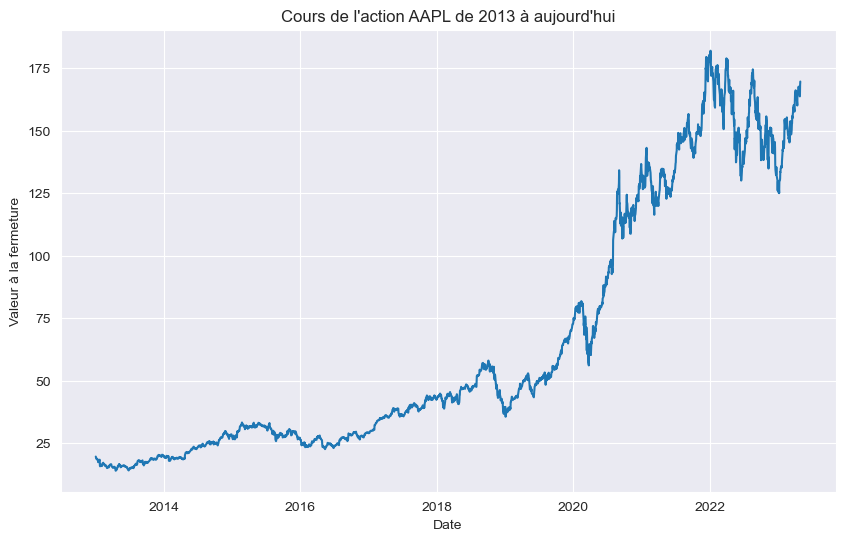

In [93]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Valeur à la fermeture')
plt.plot(df['Close'])
plt.title('Cours de l\'action AAPL de 2013 à aujourd\'hui')
plt.show()

##### Nous pouvons remarquer que les données présentent une tendance, plus remarquable
##### à partir de l'année 2020.

<Axes: ylabel='Density'>

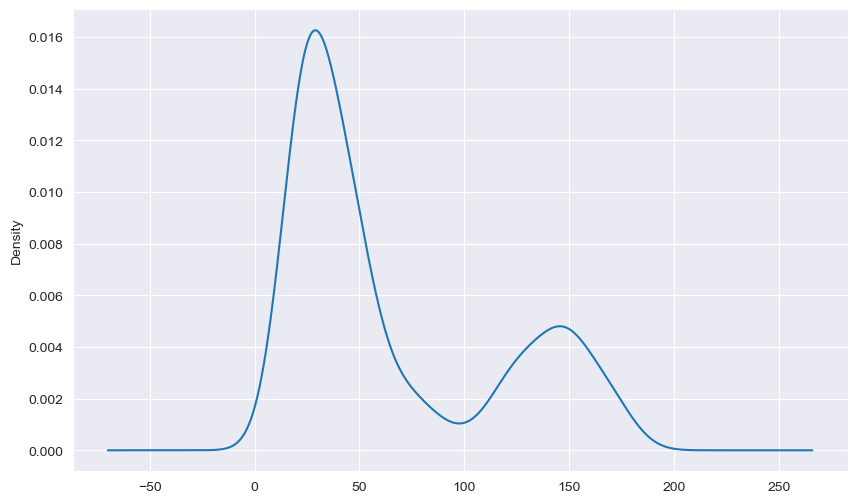

In [94]:
#Distribution du dataset
# Transformation du dataset en Serie
df_close = df['Close']
df_close.plot(kind='kde')


#### Test de stationnarité
    *  D'après le plot précedent, on a l'impression que nos données ne suivent
    pas de tendance et non pas de saisonnalité.
    *  Pour être sûr, nous allons effectuer un ou des test de stationnarité

##### IV.1 Test de Dickey Fuller augmenté

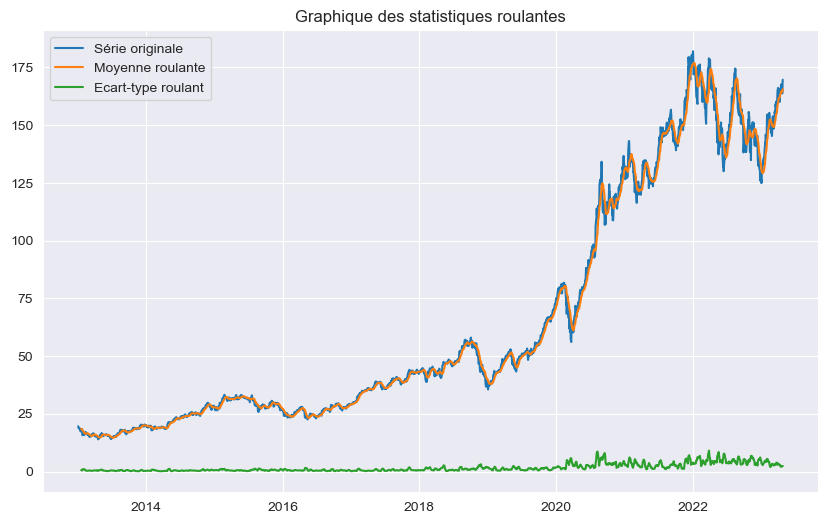

Test de Dickey-Fuller augmenté :
Statistique du test                   0.258934
p-value                               0.975380
Nombre de retards utilisés           22.000000
Nombre d'observations utilisées    2576.000000
Valeur critique (1%)                 -3.432891
Valeur critique (5%)                 -2.862663
Valeur critique (10%)                -2.567368
dtype: float64


In [95]:
from statsmodels.tsa.stattools import adfuller

def tester_stationnarite_ARIMA(series_temporelle):
    # Calcul des statistiques roulantes
    fenetre_roulante = 13
    moy_roul = series_temporelle.rolling(window=fenetre_roulante).mean()
    ecart_type_roul = series_temporelle.rolling(window=fenetre_roulante).std()

    # Tracé des statistiques roulantes
    plt.plot(series_temporelle, label='Série originale')
    plt.plot(moy_roul, label='Moyenne roulante')
    plt.plot(ecart_type_roul, label='Ecart-type roulant')
    plt.legend()
    plt.title('Graphique des statistiques roulantes')
    plt.show()

    # Test de Dickey-Fuller augmenté
    print("Test de Dickey-Fuller augmenté :")
    resultat_test_dft = adfuller(series_temporelle, autolag='AIC')
    resultat_test_dft_pandas = pd.Series(resultat_test_dft[0:4], index=['Statistique du test', 'p-value', 'Nombre de retards utilisés', 'Nombre d\'observations utilisées'])

    for cle, valeur in resultat_test_dft[4].items():
        resultat_test_dft_pandas[f'Valeur critique ({cle})'] = valeur

    print(resultat_test_dft_pandas)
tester_stationnarite_ARIMA(df_close)

##### IV.2 Interpretation du résultat
     La p_value étant supérieure à 5%(0.05), on ne peut pas rejeter  l'hypothèse nulle
     qui est la série est stationnaire.
     Cela implique que la série temporelle présente une tendance, une saisonnalité ou une
     variance qui varie dans le temps. Elle n'est donc pas stationnaire.


/Users/boubacar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


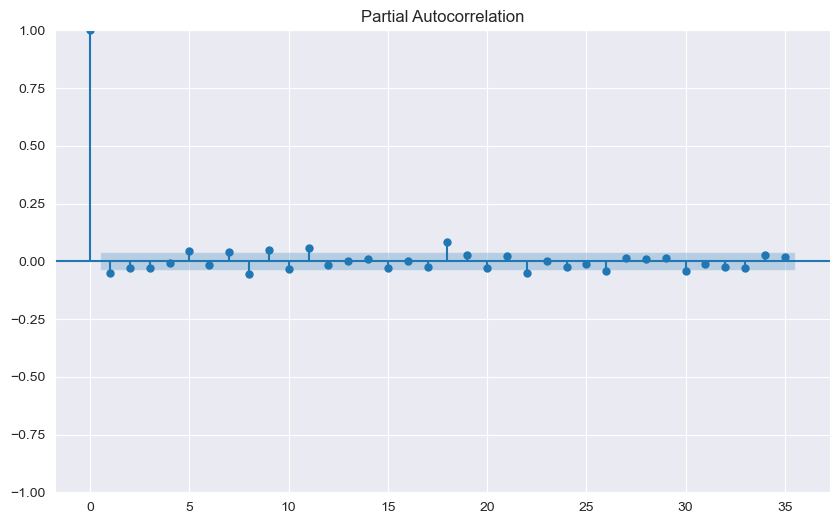

In [96]:
from statsmodels.graphics.tsaplots import plot_pacf

def frequence_saisonnalité_ARIMA(données):
    plot_pacf(données.diff().dropna())
frequence_saisonnalité_ARIMA(df_close)

#### Choix du modèle et de la période

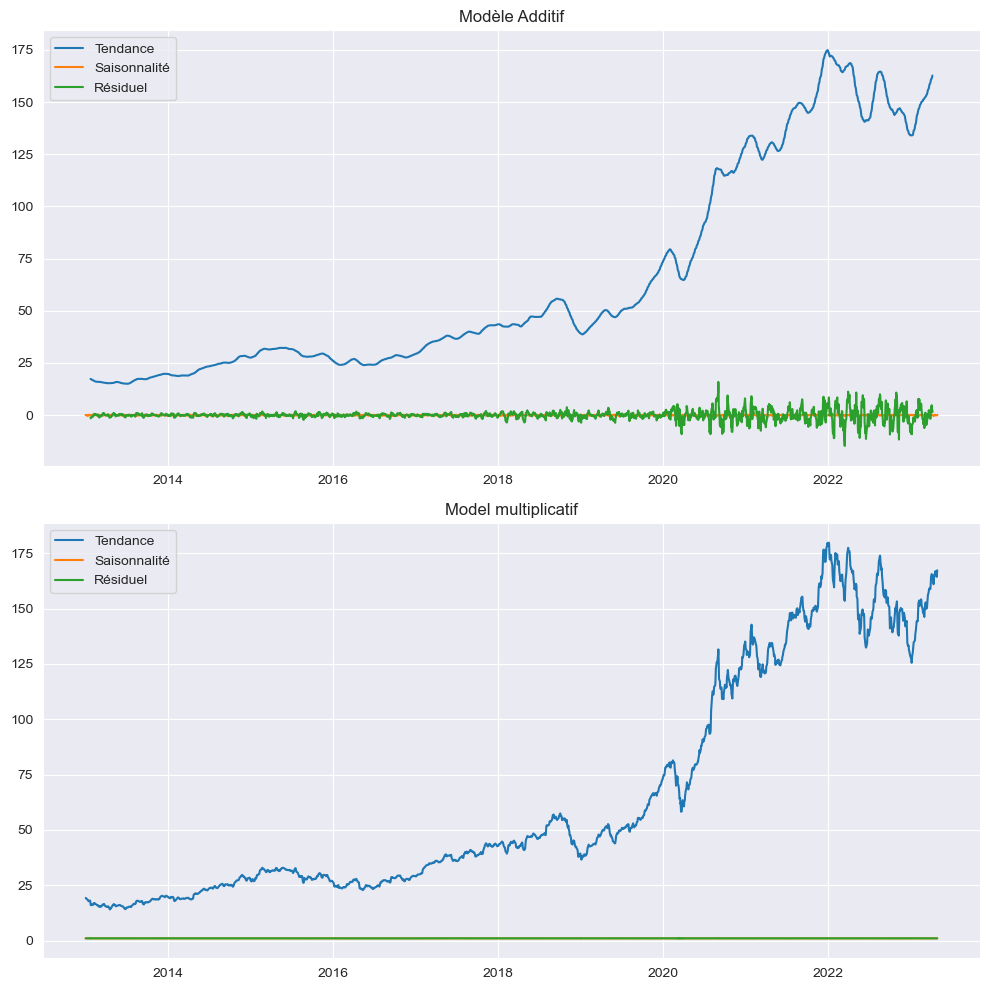

In [97]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def model_ARIMA(données):

    # Modélisations par un modèle additif et un modèle multiplicatif
    # Pour choisir le meilleur modèle
    res1 = seasonal_decompose(données, model='additive', period=30)
    res2 = seasonal_decompose(données, model='multiplicative', period=3)


    fig, axs = plt.subplots(2, 1, figsize=(10, 10)) # Taille de la fenêtre

    # # Modèle additif
    axs[0].plot(res1.trend, label='Tendance')
    axs[0].plot(res1.seasonal, label='Saisonnalité')
    axs[0].plot(res1.resid, label='Résiduel')
    axs[0].legend()
    axs[0].set_title('Modèle Additif')

    # Modèle multiplicatif
    axs[1].plot(res2.trend, label='Tendance')
    axs[1].plot(res2.seasonal, label='Saisonnalité')
    axs[1].plot(res2.resid, label='Résiduel')
    axs[1].legend()
    axs[1].set_title('Model multiplicatif')

    plt.tight_layout()
    plt.show()

model_ARIMA(df_close)


#### III. 3 Interprétation

    *   En regardant les deux differents grahiques, nous pouvons remarquer qu'il n'ya pas
        une très grande difference au niveau des courbes des tendaces.

    *   Par contre, nous pouvons remarquer les valeurs des résidus sont beaucoup plus important
        au niveau du modèle additif.
        Nous allons donc opter pour un modèle multiplicatif

<Figure size 1000x600 with 0 Axes>

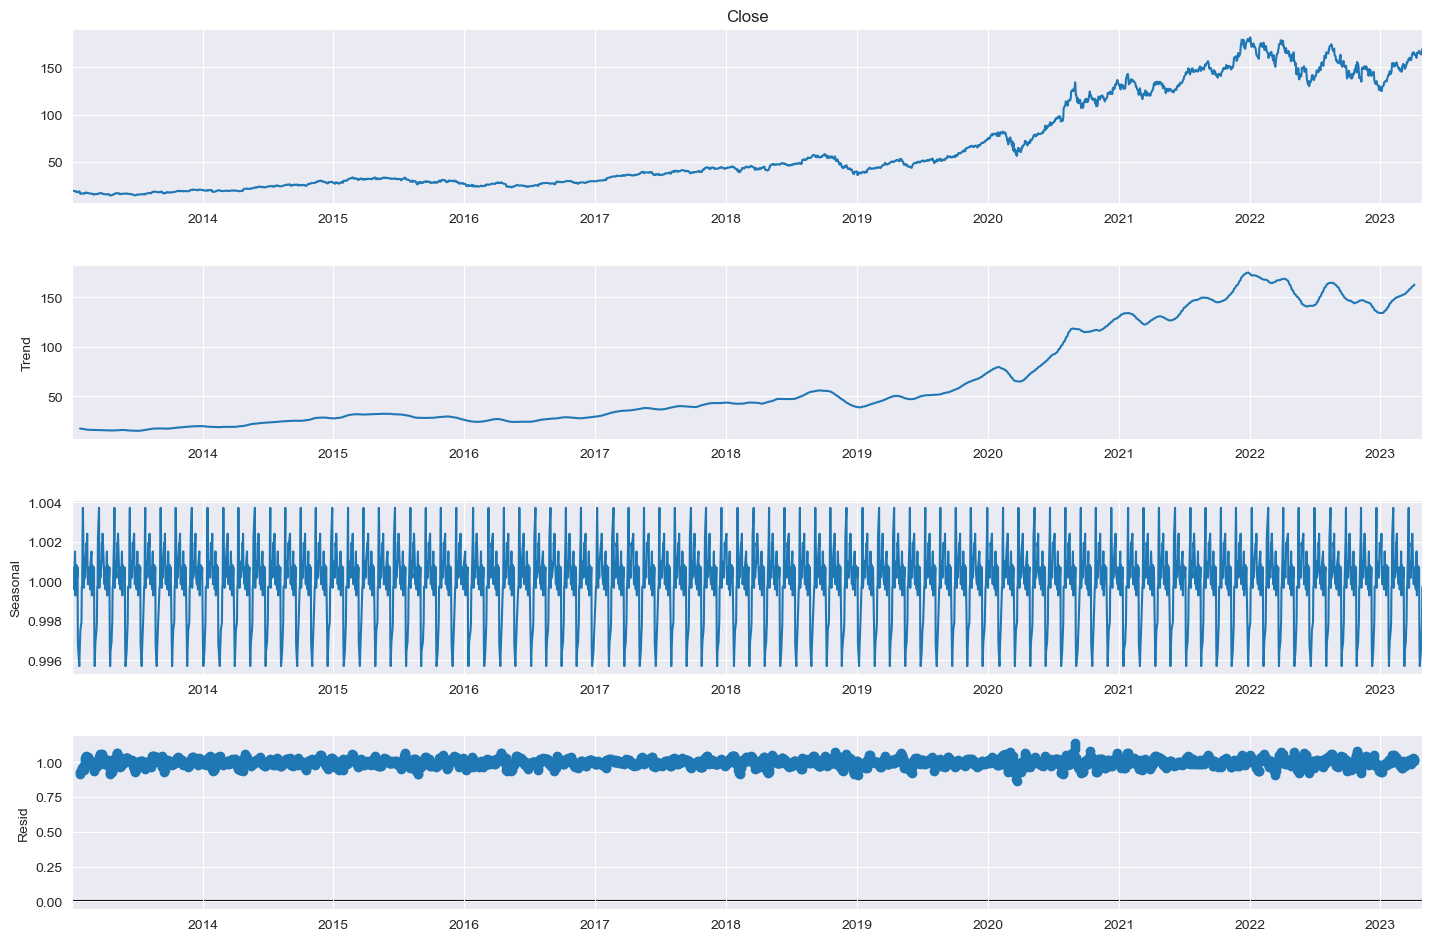

In [98]:
# Séparation des données par tendance et saisonnalité
# à l'aide du modèle multiplicatif avec une période mensuelle(30 jours)

division = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = division.plot()
fig.set_size_inches(15, 10)

##### Stationnarité des données
    Il existe plusieurs méthodes pour stationnariser des données.
    Elles peuvent varier en fonction de la nature de la tendance des données.

    Si les données ont une tendance exponentielle, comme c'est notre cas ici,
    appliquer le log aux données peut être une prémière solution.

######    On teste si les données sont stationnaires, sinon on passe par une nouvelle méthode
##### pour les rendre stationnaire

###### p-value = 0.9 > 0.05, on rejette donc l'hypothèse nulle : la série est stationnaire
###### On passe donc aux ordres de differentiation pour stationnariser la serie

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


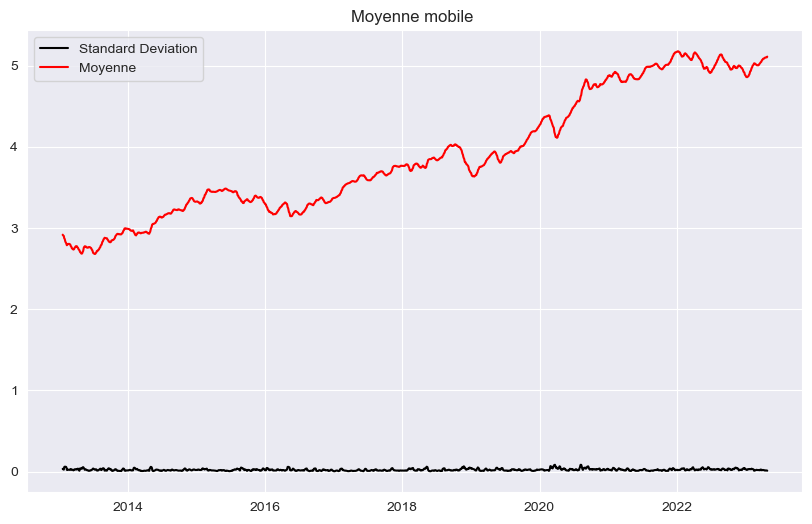

In [99]:
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moyenne_mobile = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moyenne mobile ')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moyenne_mobile, color="red", label = "Moyenne")
plt.legend()
plt.show()

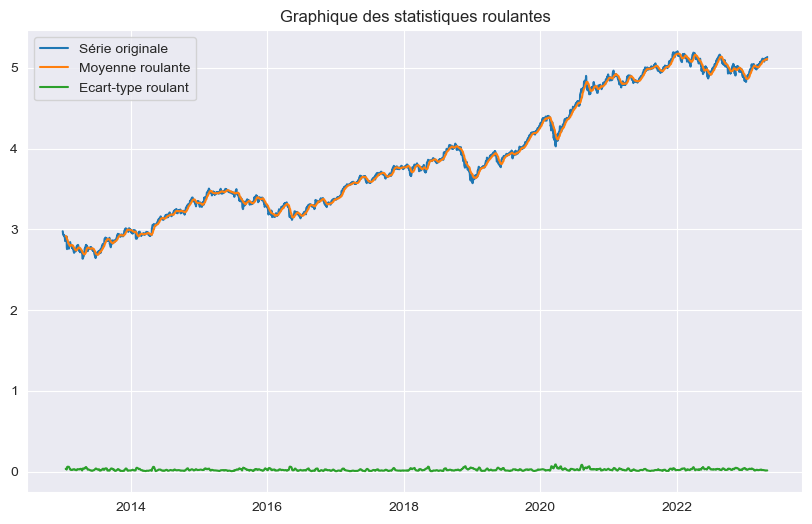

Test de Dickey-Fuller augmenté :
Statistique du test                  -0.257671
p-value                               0.931289
Nombre de retards utilisés            9.000000
Nombre d'observations utilisées    2589.000000
Valeur critique (1%)                 -3.432878
Valeur critique (5%)                 -2.862657
Valeur critique (10%)                -2.567365
dtype: float64


In [100]:
tester_stationnarite_ARIMA(df_log)

###### p-value > 0.05, nos données ne sont toujours pas stationnaires

    On va donc passer à la prochaine étape, faire une diffrenciation.

    source :
    http://w3.cran.univ-lorraine.fr/perso/hugues.garnier/Enseignement/TSAF/C-TSAF-Box-Jenkins_method.pdf

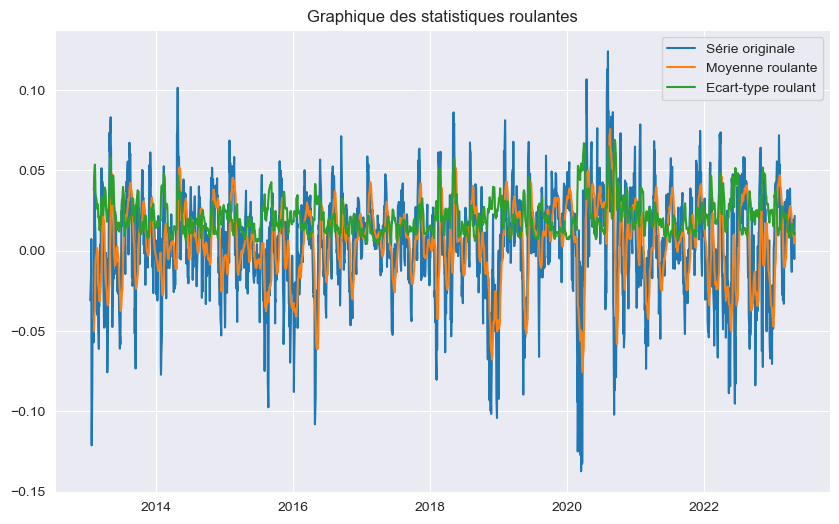

Test de Dickey-Fuller augmenté :
Statistique du test               -1.071977e+01
p-value                            3.172873e-19
Nombre de retards utilisés         1.100000e+01
Nombre d'observations utilisées    2.576000e+03
Valeur critique (1%)              -3.432891e+00
Valeur critique (5%)              -2.862663e+00
Valeur critique (10%)             -2.567368e+00
dtype: float64


In [101]:
difference = df_log - moyenne_mobile
difference.dropna(inplace= True)
tester_stationnarite_ARIMA(difference)

##### p-value << 0.05, on accepte l'hypothèse nulle: la série est stationnaire
    La serie est donc stationnaire. Il n'ya donc pas besoin de passer à
    second ordre de differentiation.


#### V. Partage des données en données d'entrainement (Train) et données de test (Test)

In [102]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_log, test_size=0.2, shuffle=False)

# Afficher la forme des données d'entraînement et de test
print("Train set shape:", train.shape) # Taille des données d'entrainement 2079
print("Test set shape:", test.shape) # Taille des données de test 520
# train.reset_index(drop=True)
# test.reset_index(drop=True)

Train set shape: (2079,)
Test set shape: (520,)


##### Affichage du graphique de la distribution des données

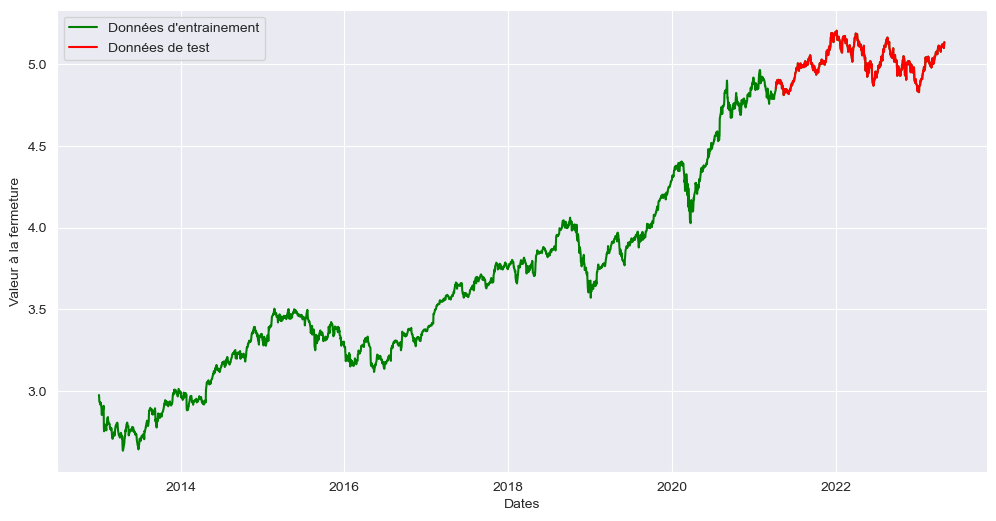

In [103]:
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Valeur à la fermeture')
plt.plot(df_log, 'green', label='Données d\'entrainement')
plt.plot(test, 'red', label='Données de test')
plt.legend()

##### V.3 Entrainement du modèle

    * Determination des paramètres p,d et q:

      Pour determiner les paramètres p,d, et, nous allons nous servir de la fonction auto_arima
      de du module  pmdarima.arima qui doit être installé avaant avec pip.

    * Cette methode nous permet de determiner de façon automatique les paramètres optimaux et deduire le
      meilleur modèle.


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10762.195, Time=0.14 sec


/Users/boubacar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10770.797, Time=0.13 sec


/Users/boubacar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10770.582, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10759.132, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10768.940, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10768.989, Time=0.14 sec


/Users/boubacar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/boubacar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/boubacar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/boubacar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10769.891, Time=0.73 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10766.968, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.288 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2079
Model:               SARIMAX(1, 1, 0)   Log Likelihood                5388.398
Date:                Mon, 01 May 2023   AIC                         -10770.797
Time:                        21:59:38   BIC                         -10753.880
Sample:                             0   HQIC                        -10764.597
                               - 2079                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

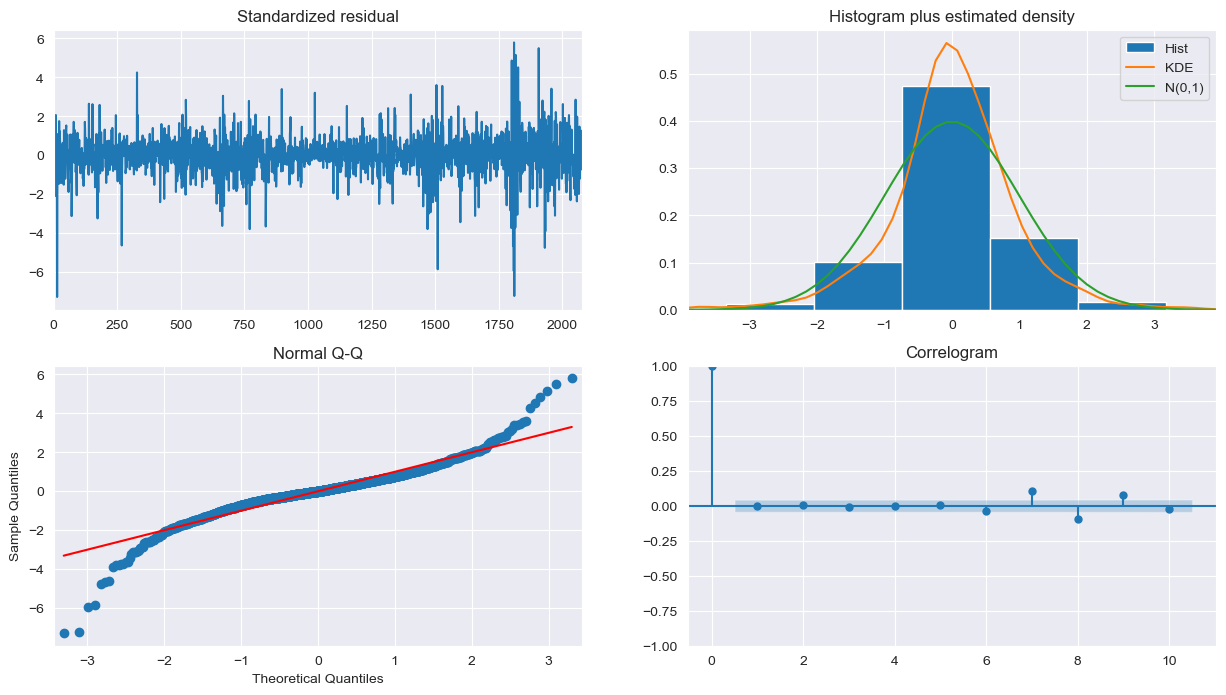

In [104]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [105]:
!pip install pmdarima

#### V.4 Interpretation des résultats

    1. Standardized residuals (résidus standardisés) :
         Ils représentent l'écart entre les valeurs observées et les valeurs prédites par
         le modèle, exprimées en termes d'écart-type. source :chatGPT
         Plus ils ont petits, plus le modèle est robuste.

    2. Histogram plus estimated density
         Les residus suivent une loi normale centrée, de moyenne 0

    3. Normal Q-Q
         Ce graphique compare la distribution des résidus du modèle avec une distribution normale théorique.
         Si les points sont alignés le long de la ligne de référence diagonale, cela indique que les résidus
         sont normalement distribués. Si les points sont courbés ou s'éloignent de la ligne de référence,
         cela indique que les résidus ne sont pas normalement distribués. source: chatGPT

    4. Correlogram
         Le correlogramme est un graphique qui montre les corrélations entre les résidus à différentes
         distances dans le temps. Les corrélations sont représentées par les barres du graphique.
         Si les barres sont toutes à l'intérieur de la zone de confiance, cela indique que les résidus
         sont aléatoires et non corrélés. Si les barres dépassent la zone de confiance, cela indique que
         les résidus présentent une autocorrélation et que le modèle n'est pas en mesure d'expliquer toute
         la variation de la série chronologique.


    * BILAN:
        En résumé,les résidus sont petits et normalement distribués, le correlogramme montre une autocorrélation minimale,
        cela indique que le modèle est capable d'expliquer la variation des données de manière satisfaisante.


In [106]:
##### V.5 Meilleur modèle (  ARIMA(1,1,0)(0,0,0)) ou  ARIMA(1,1,0)

In [107]:
from pmdarima.arima import ARIMA

train_reset = train.reset_index(drop=True)
model = ARIMA(order=(1,1,2))
fitted = model.fit(train_reset, disp=-1)
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2079
Model:               SARIMAX(1, 1, 2)   Log Likelihood                5388.273
Date:                Mon, 01 May 2023   AIC                         -10766.547
Time:                        21:59:44   BIC                         -10738.351
Sample:                             0   HQIC                        -10756.214
                               - 2079                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0014      0.001      1.812      0.070      -0.000       0.003
ar.L1         -0.5518      0.550     -1.004      0.315      -1.629       0.525
ma.L1          0.4804      0.544      0.883      0.3

##### Interpretation

        La presence de la significativité des paramètres indique que le modèle, La log-vraisemblance est de 5385.484
        et les résultats de l'AIC, BIC et HQIC indiquent que ce modèle est relativement satisfaisant en termes de
        qualité de prévision sont suffisants pour confirmer la qualité du modèle.




##### V.5 Entrainement du modèle

        Maintenant que nous savons que notre modèle ajuste biens les données, appliquons le aux
        données d'entrainement.

In [108]:
test.shape

(520,)

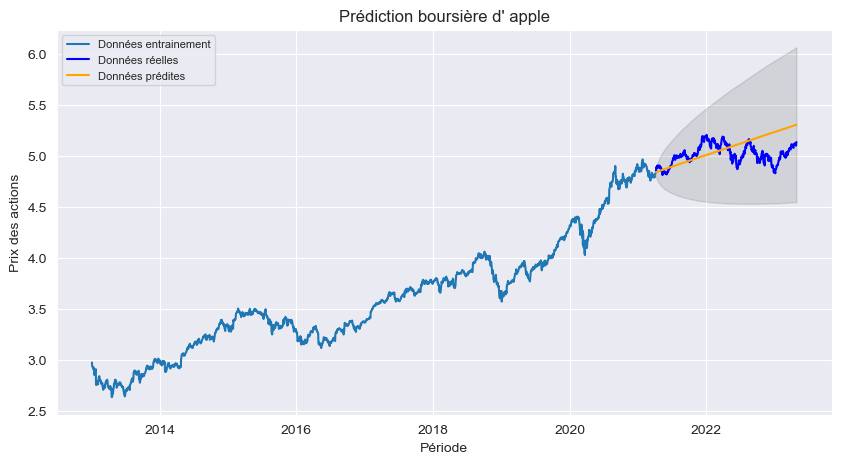

In [109]:
# Forecast
fc, conf_int = fitted.predict(n_periods=len(test), return_conf_int=True, alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc.values , index=test.index)
lower_series = pd.Series(conf_int[:, 0], index=test.index)
upper_series = pd.Series(conf_int[:, 1], index=test.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='Données entrainement')
plt.plot(test, color = 'blue', label='Données réelles')
plt.plot(fc_series, color = 'orange',label='Données prédites')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title('Prédiction boursière d''\' apple')
plt.xlabel('Période')
plt.ylabel('Prix des actions')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [110]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

# report performance
mse = mean_squared_error(test, fc.values)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc.values)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc.values))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.values - test)/np.abs(test))
print('MAPE: '+str(mape))

MSE: 0.024388975315683067
MAE: 0.12555261569611512
RMSE: 0.1561697003764913
MAPE: 0.02508769257147102


Les sorties métriques d'évaluation de performance montrent que étant faible, nous pouvonc conclure que
le modèle a plutôt une bonne performance .

In [111]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # Pour normaliseer les données
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU


In [112]:
print(data.head())
training_data = data['Close'].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(training_data.reshape(-1, 1))


                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2013-01-02  19.779285  19.821428  19.343929  19.608213  16.837114  560518000
2013-01-03  19.567142  19.631071  19.321428  19.360714  16.624586  352965200
2013-01-04  19.177500  19.236786  18.779642  18.821428  16.161516  594333600
2013-01-07  18.642857  18.903570  18.400000  18.710714  16.066452  484156400
2013-01-08  18.900356  18.996071  18.616072  18.761070  16.109690  458707200


In [113]:
training_data = data['Close'].values
window_size = 70
X_train = []
y_train = []

for i in range(window_size, len(scaled_data)):
    X_train.append(scaled_data[i - window_size:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train)
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

[[[0.03368219]
  [0.03220953]
  [0.02900069]
  ...
  [0.00959677]
  [0.00930777]
  [0.00834511]]

 [[0.03220953]
  [0.02900069]
  [0.02834192]
  ...
  [0.00930777]
  [0.00834511]
  [0.00623068]]

 [[0.02900069]
  [0.02834192]
  [0.02864155]
  ...
  [0.00834511]
  [0.00623068]
  [0.00758859]]

 ...

 [[0.71885458]
  [0.72587583]
  [0.72153223]
  ...
  [0.89890671]
  [0.90075125]
  [0.891469  ]]

 [[0.72587583]
  [0.72153223]
  [0.72188923]
  ...
  [0.90075125]
  [0.891469  ]
  [0.89140944]]

 [[0.72153223]
  [0.72188923]
  [0.73735961]
  ...
  [0.891469  ]
  [0.89140944]
  [0.91907778]]]


In [115]:
# Compiler le modèle avec l'optimiseur "Adam" et la fonction de perte
# "mean_squared_error"
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle sur le jeu de données d'entraînement (X_train, y_train)
# pendant 100 époques (epoch) avec une taille de lot de 32
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Récupération  des données de test et préparation pour la prediction
# en les mettant à l'échelle avec un objet de mise à l'échelle
test_data = data[len(data) - len(y_train) - window_size:]['Close'].values
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))

# Création séquences d'entrée pour le modèle
X_test = []
y_test = test_data[window_size:]

for i in range(window_size, len(scaled_test_data)):
    X_test.append(scaled_test_data[i - window_size:i, 0])

# Transformation des séquences en tableau numpy et les remodeler pour qu'elles
# correspondent à l'entrée du modèle
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Faire des prédictions sur les données de test
predictions = model.predict(X_test)

# Remettre les prédictions à l'échelle d'origine en utilisant l'objet de mise
# à l'échelle inverse
predictions = scaler.inverse_transform(predictions)

# Calcul du coefficient de détermination (R²) pour mesurer la performance du
# modèle sur les données de test
test_data = data[len(data) - len(y_train) - window_size:]['Close'].values

# Calcul de  la moyenne des valeurs de fermeture de la série temporelle de test
mean = np.mean(test_data)

# Calcul de la somme totale des carrés des différences entre les valeurs de
# fermeture de la série temporelle de test et leur moyenne
total_sum_of_squares = np.sum((test_data - mean) ** 2)

# Calcul de  la somme résiduelle des carrés des différences entre les
# prédictions du modèle et les valeurs réelles de fermeture de la série
# temporelle de test
residual_sum_of_squares = np.sum((predictions -
                                  test_data[window_size:].reshape(-1, 1)) ** 2)

# Calcul du  pourcentage de bonnes prédictions en soustrayant la somme résiduelle
# des carrés de la somme totale des carrés, en divisant par la somme totale des
# carrés et en multipliant par 100
taux_bonnePrediction  = (1 - (residual_sum_of_squares / total_sum_of_squares))*100
print('La performance est de {:.2f}%'.format(taux_bonnePrediction))


Epoch 1/100
80/80 [==============================] - 5s 37ms/step - loss: 1.5520e-04
Epoch 2/100
80/80 [==============================] - 3s 36ms/step - loss: 1.0652e-04
Epoch 3/100
80/80 [==============================] - 3s 37ms/step - loss: 1.1522e-04
Epoch 4/100
80/80 [==============================] - 3s 37ms/step - loss: 1.2535e-04
Epoch 5/100
80/80 [==============================] - 3s 37ms/step - loss: 1.2227e-04
Epoch 6/100
80/80 [==============================] - 3s 37ms/step - loss: 1.1904e-04
Epoch 7/100
80/80 [==============================] - 3s 37ms/step - loss: 1.8079e-04
Epoch 8/100
80/80 [==============================] - 3s 37ms/step - loss: 1.1752e-04
Epoch 9/100
80/80 [==============================] - 3s 36ms/step - loss: 1.0432e-04
Epoch 10/100
80/80 [==============================] - 3s 36ms/step - loss: 1.1205e-04
Epoch 11/100
80/80 [==============================] - 3s 36ms/step - loss: 1.2079e-04
Epoch 12/100
80/80 [==============================] - 3s 36ms/s

(2529,)



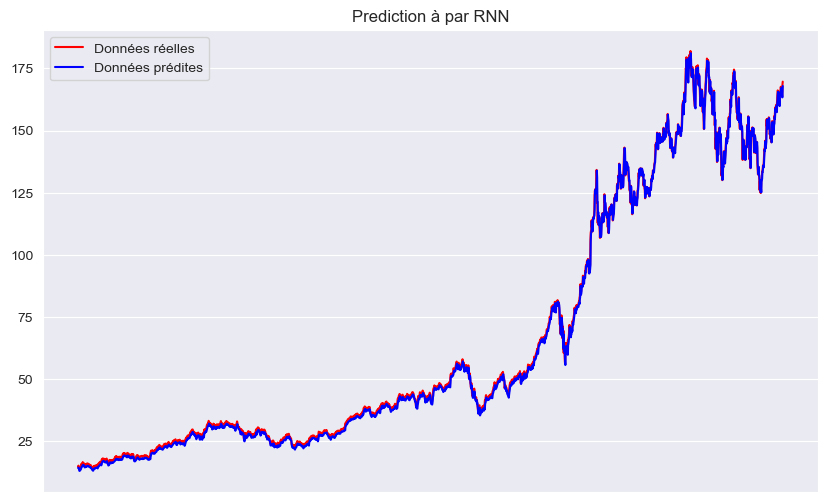

In [116]:
import matplotlib.pyplot as plt
predictions = pd.Series(predictions.ravel())
predictions = predictions.reset_index(drop=True)
print(predictions.shape)
# Tracer les données réelles vs prédites
# Tracer les données réelles vs prédites pour 2010-2023

plt.gca().xaxis.set_visible(False)
plt.plot(y_test, color='red', label='Données réelles')
plt.plot(predictions, color='blue', label='Données prédites')
plt.title('Prediction à par RNN')
print()
plt.legend()
plt.show()

##### Comparaison des deux modèles

Niveau Précision:
    Le resultat produit par les deux modèles montrent que le modèle RNN est plus précis

Niveau vitesse d'éxécution:
    Le modèle ARIMA est moins couteux en temps. Céla est du est au très grand nombre de boucle de
    rétroaction dans le modèle RNN.
  Tableau récapitulatif
 _______
Modèle |  Temps    |  Precision    |  Score
________
ARIMA  | Rapide    | Moins précis  | 97<score<98
_______
RNN    | Lent      | Plus Précis   | 99<score<100

 Dans la partie réseau de neuronnes récurrents, je me suis servi de ChatGpt, notamment sur
le calcul du taux de bonne prediction.